# A simple 2D Multimodal Flow Matching model

This notebook trains and evaluates a multimodal FM model that jointly handles
a discrete modality (categorical data) and a continuous modality (real‑valued 2‑D data).

Dataset: 2D discrete/continuous checkerboard
Model (probability denoiser/velocity): MLPs for each modality and a shared Transformer trunk

## Imports and init device

In [ ]:
import time

from typing import Any, Dict, List

# visualization
import matplotlib.pyplot as plt
import torch
from flow_matching.path import AffineProbPath, MixtureDiscreteProbPath
from flow_matching.path.scheduler import (
    CondOTScheduler,  # continuous scheduler (training)
    PolynomialConvexScheduler,  # discrete scheduler (training)
)

# flow_matching
from flow_matching.utils.multimodal import Flow
from torch import nn, Tensor

# To avoid meshgrid warning
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="torch")

In [2]:
if torch.cuda.is_available():
    device = "cuda:0"
    print("Using GPU")
elif torch.backends.mps.is_available():
    device = "mps"
    print("Using MPS")
else:
    device = "cpu"
    print("Using CPU")

Using MPS


In [3]:
torch.manual_seed(42)

## Shared model

In [4]:
class SharedTransformer(nn.Module):
    """
    Shared Transformer trunk used by both modalities.

    Args:
        hidden_dim (int): The hidden dimension of the model.
        nhead (int): The number of attention heads.
        num_layers (int): The number of TransformerEncoder layers.
    """

    def __init__(self, hidden_dim: int = 128, nhead: int = 4, num_layers: int = 2):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass through the shared Transformer.

        Args:
            x (Tensor): Input tensor of shape (sequence_length, batch_size, hidden_dim).

        Returns:
            Tensor: Output tensor of the same shape as input.
        """
        return self.transformer(x)

## Datasets

In [5]:
def inf_train_gen_discrete(
    n_grid_points: int = 128,
    batch_size: int = 200,
    device: str = "cpu",
) -> Tensor:
    """
    Generate a batch of discrete (categorical) samples.
    Returns a tensor of shape (batch, 2) with integer token IDs.

    Args:
        n_grid_points (int): Number of grid points along one axis (should be divisible by 4).
        batch_size (int): Number of samples to generate.
        device (str): Device to place the tensor on.

    Returns:
        Tensor: A tensor of shape (batch_size, 2) with integer token IDs.
    """
    assert n_grid_points % 4 == 0, "grid size must be divisible by 4"
    n_grid_points //= 4

    x1 = torch.randint(low=0, high=n_grid_points * 4, size=(batch_size,), device=device)
    samples_x2 = torch.randint(
        low=0, high=n_grid_points, size=(batch_size,), device=device
    )

    x2 = (
        samples_x2
        + 2 * n_grid_points
        - torch.randint(low=0, high=2, size=(batch_size,), device=device)
        * 2
        * n_grid_points
        + (torch.floor(x1 / n_grid_points) % 2) * n_grid_points
    )
    return torch.stack([x1, x2], dim=1).long()


def inf_train_gen_continuous(batch_size: int = 200, device: str = "cpu") -> Tensor:
    """
    Generate a batch of 2-D continuous points from a checkerboard-like distribution.
    Returns a tensor of shape (batch, 2).

    Args:
        batch_size (int): Number of samples to generate.
        device (str): Device to place the tensor on.

    Returns:
        Tensor: A tensor of shape (batch_size, 2) with continuous values.
    """
    x1 = torch.rand(batch_size, device=device) * 4 - 2
    x2_ = (
        torch.rand(batch_size, device=device)
        - torch.randint(high=2, size=(batch_size,), device=device) * 2
    )
    x2 = x2_ + (torch.floor(x1) % 2)
    data = torch.stack([x1, x2], dim=1) / 0.45
    return data.float()

## Unified multimodal model

In [ ]:
class Swish(nn.Module):
    """Swish activation (x * sigmoid(x))."""

    def forward(self, x: Tensor) -> Tensor:
        """Forward pass through the Swish activation."""
        return torch.sigmoid(x) * x


class TransformerModel(nn.Module):
    """
    A unified Transformer-based model for handling multiple modalities.

    This model processes a list of modalities, each with its own input
    and output heads, while sharing a central Transformer trunk. It is designed
    to be flexible for both discrete (categorical) and continuous data types.

    Args:
        shared_transformer (SharedTransformer): The shared TransformerEncoder module.
        modality_configs (List[Dict[str, Any]]): A list of dictionaries, each configuring a modality.
            Required keys per config:
                - 'type': 'discrete' or 'continuous'.
                - 'length': The sequence length for this modality's tokens.
                If 'type' is 'discrete':
                - 'vocab_size': The size of the vocabulary.
                If 'type' is 'continuous':
                - 'input_dim': The feature dimension of the continuous data.
        time_dim (int): The dimension of the time embedding.
        hidden_dim (int): The hidden dimension of the model and transformer.

    Raises:
        ValueError: If an unknown modality type is provided.
    """

    def __init__(
        self,
        shared_transformer: SharedTransformer,
        modality_configs: List[Dict[str, Any]],
        time_dim: int = 1,
        hidden_dim: int = 128,
    ):
        super().__init__()
        self.shared = shared_transformer
        self.modality_configs = modality_configs
        self.seq_lengths = [config["length"] for config in modality_configs]

        self.input_embedders = nn.ModuleList()
        self.time_embedders = nn.ModuleList()
        self.input_projectors = nn.ModuleList()
        self.output_heads = nn.ModuleList()
        self.activations = nn.ModuleList()

        for config in self.modality_configs:
            self.time_embedders.append(nn.Linear(1, time_dim))
            self.input_projectors.append(nn.Linear(hidden_dim + time_dim, hidden_dim))
            self.activations.append(Swish())

            if config["type"] == "discrete":
                self.input_embedders.append(
                    nn.Embedding(config["vocab_size"], hidden_dim)
                )
                self.output_heads.append(nn.Linear(hidden_dim, config["vocab_size"]))
            elif config["type"] == "continuous":
                self.input_embedders.append(nn.Linear(config["input_dim"], hidden_dim))
                self.output_heads.append(nn.Linear(hidden_dim, config["input_dim"]))
            else:
                raise ValueError(f"Unknown modality type: {config['type']}")

    def forward(
        self, x_modalities: List[Tensor], t_modalities: List[Tensor]
    ) -> List[Tensor]:
        """
        Forward pass for multiple modalities.

        Args:
            x_modalities (List[Tensor]): A list of input tensors, one for each modality.
                          Shape for discrete: (batch, length)
                          Shape for continuous: (batch, input_dim)
            t_modalities (List[Tensor]): A list of time tensors, one for each modality.
                          Shape for all: (batch, 1)

        Returns:
            List[Tensor]: A list of output tensors, one for each modality.
        """
        embeddings = []

        # 1. Process each modality through its specific input head
        for i, (x, t, config) in enumerate(
            zip(x_modalities, t_modalities, self.modality_configs)
        ):
            # Embed time and expand to match sequence length
            t_emb = self.time_embedders[i](t.unsqueeze(-1))
            t_emb = t_emb.unsqueeze(1).expand(-1, config["length"], -1)

            # Embed input based on modality type
            if config["type"] == "discrete":
                x_emb = self.input_embedders[i](x)  # (B, length, hidden_dim)
            else:  # continuous
                x_emb = self.input_embedders[i](x)  # (B, hidden_dim)
                x_emb = x_emb.unsqueeze(1)  # (B, 1, hidden_dim)

            # Combine, project, and activate
            combined = torch.cat([x_emb, t_emb], dim=-1)
            h = self.input_projectors[i](combined)
            h = self.activations[i](h)

            # Prepare for transformer (seq_len, batch, hidden_dim)
            embeddings.append(h.permute(1, 0, 2))

        # 2. Concatenate all modality embeddings and pass through shared transformer
        full_sequence = torch.cat(embeddings, dim=0)
        transformer_out = self.shared(full_sequence)

        # 3. Split the output and process through specific output heads
        output_chunks = torch.split(transformer_out, self.seq_lengths, dim=0)
        results = []
        for i, chunk in enumerate(output_chunks):
            # (length, B, hidden_dim) -> (B, length, hidden_dim)
            chunk = chunk.permute(1, 0, 2)
            output = self.output_heads[i](chunk)

            # Squeeze sequence dimension if it's 1 (for continuous case)
            if output.size(1) == 1:
                output = output.squeeze(1)
            results.append(output)

        return results

## Instantiate modalities and model

In [7]:
# ---- General Hyperparameters -----------------------------------------
length = 2  # 2 tokens per sample
vocab_size = 128
added_token = 0  # uniform source distribution → no extra token
vocab_size += added_token
hidden_dim = 128

# ---- Shared transformer trunk ----------------------------------------
shared_transformer = SharedTransformer(hidden_dim=hidden_dim, nhead=4, num_layers=2).to(
    device
)

# ---- Model and Path Configuration ------------------------------------
modality_configs = [
    {
        "type": "discrete",
        "vocab_size": vocab_size,
        "length": length,
    },
    {
        "type": "continuous",
        "input_dim": length,
        "length": 1,  # This modality is treated as a single token in the sequence
    },
]

# A unified model that handles all modalities
model = TransformerModel(
    shared_transformer=shared_transformer,
    modality_configs=modality_configs,
    time_dim=1,
    hidden_dim=hidden_dim,
).to(device)

# Path definitions remain distinct per modality
discrete_path = MixtureDiscreteProbPath(scheduler=PolynomialConvexScheduler(n=2.0))
continuous_path = AffineProbPath(scheduler=CondOTScheduler())

# ---- Assemble modalities dict for Flow -------------------------------
modalities = {
    "discrete": {
        "path": discrete_path,
        # loss omitted → Flow will use MixturePathGeneralizedKL automatically
    },
    "continuous": {
        "path": continuous_path,
        # loss omitted → Flow will use MSE loss automatically
    },
}

## Instantiate the multimodal Flow model

In [8]:
flow = Flow(model=model, modalities=modalities)

# Optimizer (optimises both modality models)
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)

## Training loop

In [9]:
lr = 1e-3
batch_size = 2048
iterations = 30001
print_every = 3000
epsilon = 1e-3

source_distribution = "uniform"  # for the discrete modality

start_time = time.time()
for i in range(iterations):
    optimizer.zero_grad()

    # ---- Discrete data -------------------------------------------------
    x1_disc = inf_train_gen_discrete(
        n_grid_points=vocab_size - added_token,
        batch_size=batch_size,
        device=device,
    )
    if source_distribution == "uniform":
        x0_disc = torch.randint_like(x1_disc, high=vocab_size)
    else:  # mask case (not used here)
        raise NotImplementedError

    # ---- Continuous data -----------------------------------------------
    x1_cont = inf_train_gen_continuous(batch_size=batch_size, device=device)
    x0_cont = torch.randn_like(x1_cont)  # isotropic Gaussian prior

    # ---- Sample a common time tensor for both modalities ---------------
    t = torch.rand(batch_size, device=device) * (1 - epsilon)

    # ---- Sample from each path to obtain x_t ---------------------------
    disc_path_sample = discrete_path.sample(t=t, x_0=x0_disc, x_1=x1_disc)
    cont_path_sample = continuous_path.sample(t=t, x_0=x0_cont, x_1=x1_cont)

    # ---- Build the inputs expected by Flow.training_loss -----------
    x_1 = [x1_disc, x1_cont]
    x_t = [disc_path_sample.x_t, cont_path_sample.x_t]
    dx_t = [None, cont_path_sample.dx_t]  # NOTE: dx_t is None for discrete
    ts = [t] * 2  # NOTE: For now, both modalities share the same time

    # ---- Compute total loss and back‑propagate -------------------------
    loss, _ = flow.training_loss(x_1=x_1, x_t=x_t, dx_t=dx_t, t=ts)
    loss.backward()
    optimizer.step()

    # ---- Logging -------------------------------------------------------
    if (i + 1) % print_every == 0:
        elapsed = time.time() - start_time
        print(
            f"| iter {i+1:6d} | {elapsed*1000/print_every:5.2f} ms/step | loss {loss.item():8.3f} "
        )
        start_time = time.time()

| iter   3000 | 14.35 ms/step | loss    9.040 
| iter   6000 | 16.78 ms/step | loss    9.292 
| iter   9000 | 18.14 ms/step | loss    9.037 
| iter  12000 | 18.66 ms/step | loss    9.878 
| iter  15000 | 18.56 ms/step | loss    9.466 
| iter  18000 | 18.55 ms/step | loss    9.251 
| iter  21000 | 18.27 ms/step | loss    9.220 
| iter  24000 | 18.40 ms/step | loss    9.489 
| iter  27000 | 18.48 ms/step | loss    9.835 
| iter  30000 | 18.33 ms/step | loss    9.114 


## Sampling from the trained multimodal model

In [10]:
x_init = [
    torch.randint_like(
        x1_disc, high=vocab_size
    ),  # discrete initial state (uniform categorical)
    torch.randn_like(x1_cont),  # continuous initial state (Gaussian noise)
]

flow.eval()  # switch to eval mode for sampling
samples = flow.sample(x_init=x_init, device=device, steps=1000)

## Visualization

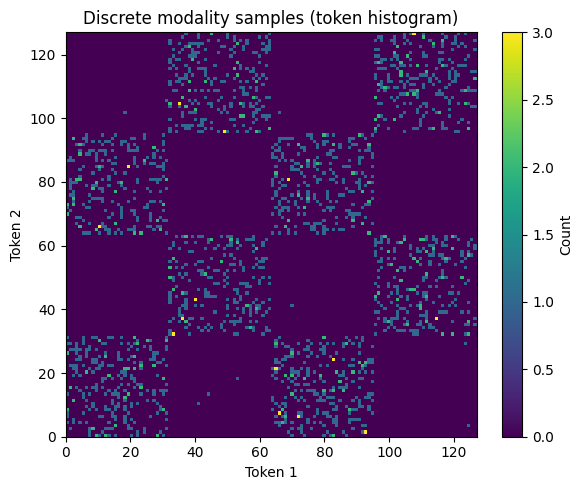

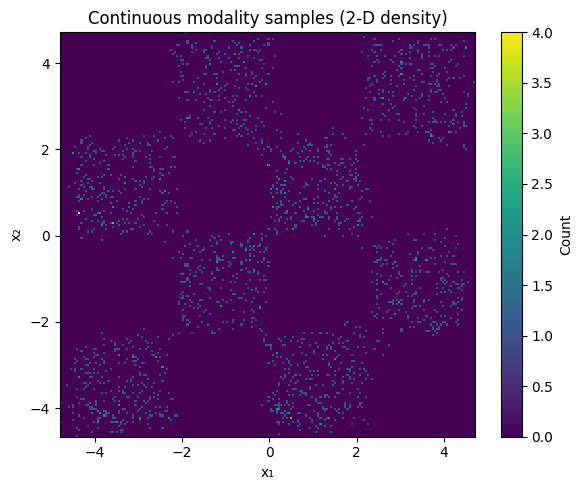

In [11]:
# ---- Discrete modality -------------------------------------------------
discrete_samples = samples[0].cpu().numpy()  # shape (N, 2) integer tokens
vocab = vocab_size

# Plot a 2‑D histogram of the discrete samples
plt.figure(figsize=(6, 5))
plt.hist2d(
    discrete_samples[:, 0],
    discrete_samples[:, 1],
    bins=vocab,
    cmap="viridis",
)
plt.title("Discrete modality samples (token histogram)")
plt.xlabel("Token 1")
plt.ylabel("Token 2")
plt.colorbar(label="Count")
plt.tight_layout()
plt.show()

# ---- Continuous modality -----------------------------------------------
continuous_samples = samples[1].cpu().numpy()  # shape (N, 2)

# Plot a 2‑D histogram of the continuous samples
plt.figure(figsize=(6, 5))
plt.hist2d(
    continuous_samples[:, 0],
    continuous_samples[:, 1],
    bins=200,
    cmap="viridis",
)
plt.title("Continuous modality samples (2-D density)")
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.colorbar(label="Count")
plt.tight_layout()
plt.show()